In [1]:
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
# torch with cuda version to train on gpu on local machine

In [2]:
# !pip install pydicom -q
# !pip install torch -q
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
from IPython.display import clear_output

In [4]:
plt.style.use('fivethirtyeight')

In [5]:
!nvidia-smi -L 

GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-29479ef5-053a-094c-4434-2320ebf6baf3)


In [6]:
from pydicom import dcmread

In [7]:
from glob import glob

In [8]:
Path = 'C:Documents/ProjectData/'

In [9]:
train_images = [dcmread(name).pixel_array for name in tqdm(glob(Path+'train/*'))]
val_images = [dcmread(name).pixel_array for name in tqdm(glob(Path+'val/*'))]
test_images = [dcmread(name).pixel_array for name in tqdm(glob(Path+'test/*'))]

  0%|          | 0/10300 [00:00<?, ?it/s]

  0%|          | 0/9001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

In [10]:
train_images = np.stack(train_images).astype(float)
val_images = np.stack(val_images).astype(float)
test_images = np.stack(test_images).astype(float)


In [11]:
mean = train_images.mean()
std = train_images.std()
train_images = (train_images-mean)/std
val_images = (val_images-mean)/std
test_images = (test_images-mean)/std

In [12]:
max_val = (train_images.max() - train_images.min())**2

In [13]:
def renormalize_image(picture, mean=mean, std=std):
    return picture * std + mean

In [14]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

from functools import lru_cache

In [15]:
class Dset(Dataset):
    def __init__(self, images, history_size, stride=10):
        self.images = images
        self.history_size = history_size
        self.stride = stride

    def __len__(self):
        return len(self.images) - self.history_size*self.stride
    
#     @lru_cache(maxsize=None)
    def __getitem__(self, i):
        y = torch.FloatTensor(self.images[i+self.history_size*self.stride])
        x = torch.FloatTensor(self.images[i:i+self.history_size*self.stride:self.stride])
        return x, y
    
train_loader = DataLoader(Dset(train_images, 5), 32)
val_loader = DataLoader(Dset(val_images, 5), 32)
test_loader = DataLoader(Dset(test_images, 5), 32)

In [16]:
class conv(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, frame_size):

        super(conv, self).__init__()  

        self.activation = nn.ReLU()
        self.out_scale = 4
        
        self.conv = nn.Conv2d(
            in_channels + out_channels, 
            self.out_scale * out_channels, 
            kernel_size=kernel_size, 
            padding=padding)           


        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):

        
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input = torch.sigmoid(i_conv + self.W_ci * C_prev)
        skip = torch.sigmoid(f_conv + self.W_cf * C_prev)

        out_c = skip * C_prev + input * self.activation(C_conv)

        out = torch.sigmoid(o_conv + self.W_co * out_c )


        return out * self.activation(out_c), out_c

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        self.conv = conv(in_channels, out_channels, 
        kernel_size, padding, frame_size)

    def forward(self, X):

        batch_size, _, seq_len, height, width = X.size()


        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width, device=device)
        


        H = torch.zeros(batch_size,
                        self.out_channels,
                        height, 
                        width,
                        device=device)


        C = torch.zeros(batch_size,
                        self.out_channels,
                        height, 
                        width, 
                        device=device)


        for time_step in range(seq_len):
            H, C = self.conv(X[:,:,time_step], H, C)

            output[:,:,time_step] = H

        return output

In [19]:
class ConvModel(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding, 
    frame_size, num_layers):

        super(ConvModel, self).__init__()

        self.total_block = []
        self.total_block.append(
            ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                frame_size=frame_size)
        )
        self.total_block.append(nn.BatchNorm3d(num_features = num_kernels))
        for l in range(2, num_layers+1):
            self.total_block.append(
                ConvLSTM(
                in_channels=num_kernels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                frame_size=frame_size),
            )
            self.total_block.append(nn.BatchNorm3d(num_features=num_kernels))
            
        self.total_block = nn.Sequential(*self.total_block)
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):

        output = self.total_block(X)
        output = self.conv(output[:,:,-1])
        
        return output

In [20]:
model = ConvModel(num_channels=1, num_kernels=10, 
    kernel_size=(3, 3), padding=(1, 1), 
    frame_size=(736, 64), num_layers=3).to(device)

In [21]:
optim = torch.optim.Adam(model.parameters(), lr=1e-4)


class Loss:
    def __init__(self, a=0.5):
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()
        self.a = a

    def __call__(self, y, pred):
        return 100 * (self.a*self.mse(y, pred) + (1 - self.a)*self.mae(y, pred))


criterion = Loss()

In [22]:
def psnr(predicted_image, target_image):
    batch_size = predicted_image.size(0)
    mse_err = (
        (predicted_image.detach().cpu() - target_image.cpu())
        .pow(2).sum(dim=1)
        .view(batch_size, -1).mean(dim=1)
    )

    psnr = 10 * (max_val / mse_err).log10()
    return psnr.mean()

In [23]:
def gaussian(window_size: int, sigma: float):
    def gauss_fcn(x):
        return -(x - window_size // 2) ** 2 / float(2 * sigma ** 2)
    gauss = torch.stack([
        torch.exp(torch.tensor(gauss_fcn(x))) for x in range(window_size)
    ])
    return gauss / gauss.sum()

def get_gaussian_kernel2d(
    ksize,
    sigma
):
    ksize_x, ksize_y = ksize
    sigma_x, sigma_y = sigma
    kernel_x: torch.Tensor = gaussian(ksize_x, sigma_x)
    kernel_y: torch.Tensor = gaussian(ksize_y, sigma_y)
    kernel_2d: torch.Tensor = torch.matmul(
        kernel_x.unsqueeze(-1), kernel_y.unsqueeze(-1).t())
    return kernel_2d

In [24]:
class SSIM(nn.Module):

    def __init__(self, window_size: int):
        super().__init__()
        self._window_size = window_size
        self._max_val = np.sqrt(max_val)

        self.window = get_gaussian_kernel2d(
            (window_size, window_size), (1.5, 1.5))
        self.padding = (window_size - 1) // 2

        self.C1: float = (0.01 * self._max_val) ** 2
        self.C2: float = (0.03 * self._max_val) ** 2

    def filter2D(
        self, input: torch.Tensor, kernel: torch.Tensor, channel: int
    ) -> torch.Tensor:
        return F.conv2d(input, kernel, padding=self.padding, groups=channel)

    def forward(self, image1, image2):

        image2 = image2.unsqueeze(1)
        b, c, h, w = image1.shape
        tmp_kernel = self.window.to(image1.device).to(image1.dtype)
        kernel = tmp_kernel.repeat(c, 1, 1, 1)


        mu1 = self.filter2D(image1, kernel, c)
        mu2 = self.filter2D(image2, kernel, c)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2


        sigma1_sq = self.filter2D(image1 * image1, kernel, c) - mu1_sq
        sigma2_sq = self.filter2D(image2 * image2, kernel, c) - mu2_sq
        sigma12 = self.filter2D(image1 * image2, kernel, c) - mu1_mu2

        ssim_map = ((2 * mu1_mu2 + self.C1) * (2 * sigma12 + self.C2)) / \
            ((mu1_sq + mu2_sq + self.C1) * (sigma1_sq + sigma2_sq + self.C2))


        return ssim_map.mean().item()

ssim = SSIM(11)

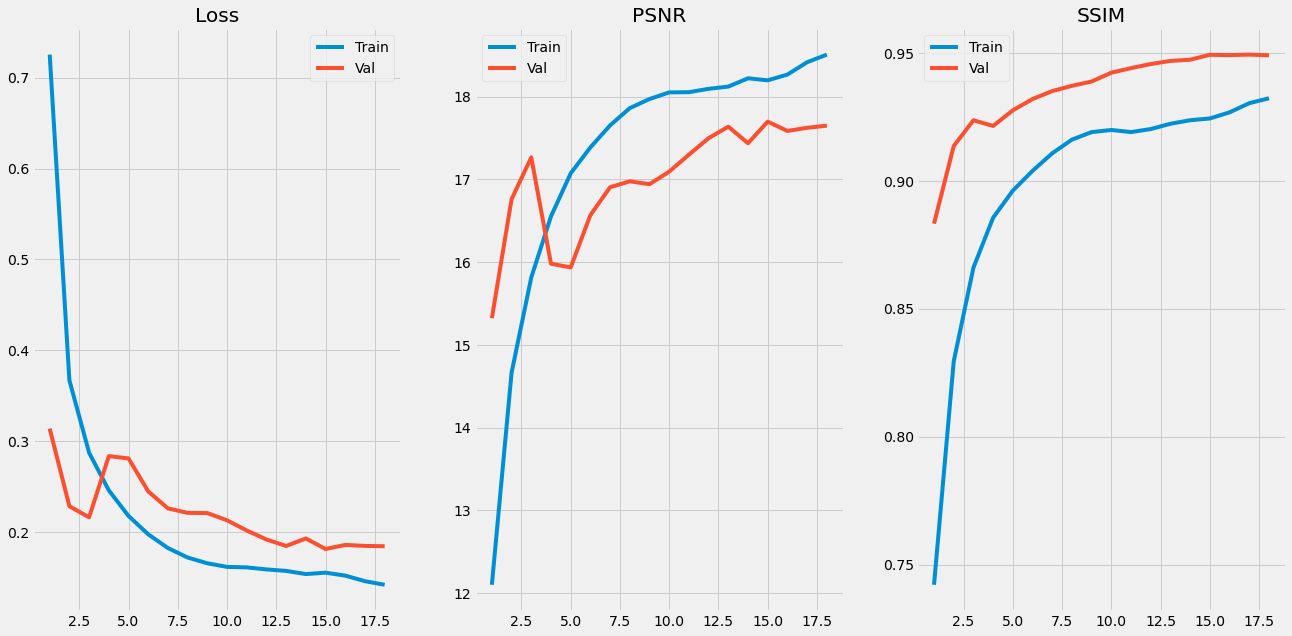

Epoch 19/50:   0%|          | 0/321 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
num_epochs = 50

train_history = []
val_history = []
psnr_train = []
psnr_val = []
ssim_train_history = []
ssim_val_history = []





for epoch in range(1, num_epochs+1):
    
    psnr_train_value = 0
    psnr_val_value = 0
    ssim_train = 0
    ssim_val = 0
    
    train_loss = 0                                                 
    model.train()                                                  
    for batch_num, (input, target) in enumerate(tqdm(train_loader, leave=False, desc = f'Epoch {epoch}/{num_epochs}')):  
        input = input.unsqueeze(1).to(device)
        target = target.to(device)

        output = model(input)
        psnr_train_value += psnr(output, target)
        ssim_train += ssim(output, target)
        loss = criterion(output.flatten(), target.flatten())       
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()                                        
        train_loss += loss.item()
        input = input.cpu()
        del input
        target = target.cpu()
        del target
    train_loss /= len(train_loader.dataset)
    train_history.append(train_loss)
    psnr_train.append(psnr_train_value/len(train_loader))
    ssim_train_history.append(ssim_train/len(train_loader))
    


    val_loss = 0                                                 
    model.eval()                                                   
    with torch.no_grad():                                          
        for input, target in val_loader:
            input = input.unsqueeze(1).to(device)
            target = target.to(device)                         
            output = model(input)
            ssim_val += ssim(output, target)
            psnr_val_value += psnr(output, target)
            loss = criterion(output.flatten(), target.flatten())   
            val_loss += loss.item()
            input = input.cpu()
            del input
            target = target.cpu()
            del target
    val_loss /= len(val_loader.dataset)
    val_history.append(val_loss)
    psnr_val.append(psnr_val_value/len(val_loader))
    ssim_val_history.append(ssim_val/len(val_loader))

    clear_output()
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    axs[0].set_title('Loss')
    axs[1].set_title('PSNR')
    axs[2].set_title('SSIM')
    axs[0].plot(range(1, epoch+1), train_history, label = 'Train')
    axs[0].plot(range(1, epoch+1), val_history, label = 'Val')
    axs[1].plot(range(1, epoch+1), psnr_train, label = 'Train')
    axs[1].plot(range(1, epoch+1), psnr_val, label = 'Val')
    axs[2].plot(range(1, epoch+1), ssim_train_history, label = 'Train')
    axs[2].plot(range(1, epoch+1), ssim_val_history, label = 'Val')
    
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    plt.show();

In [26]:
torch.save(model.state_dict(), 'DLFinalProjectConvLSTM_3layers.pt')

In [27]:
x, y = next(iter(val_loader))

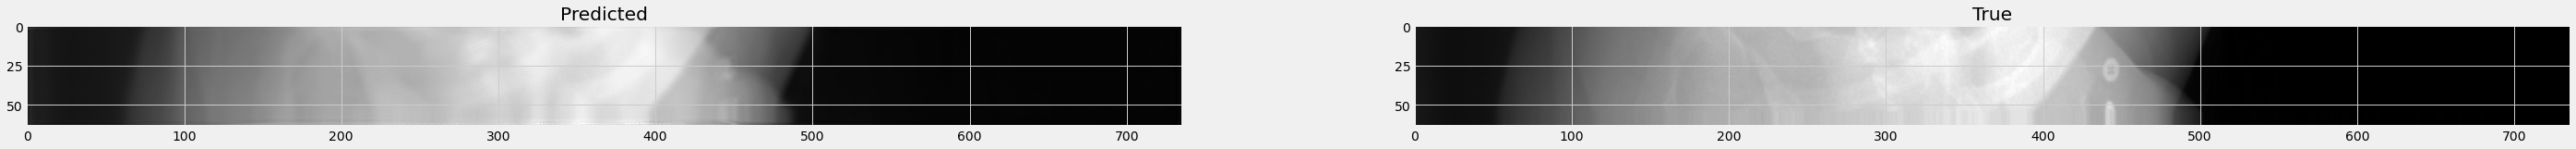

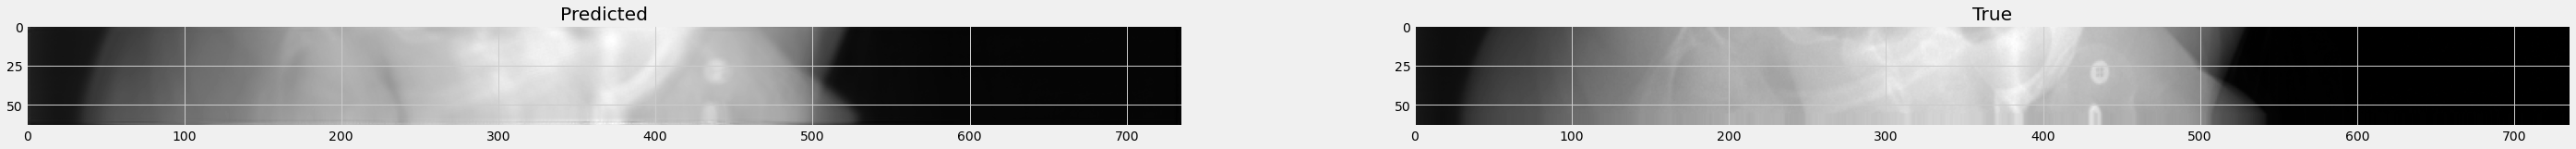

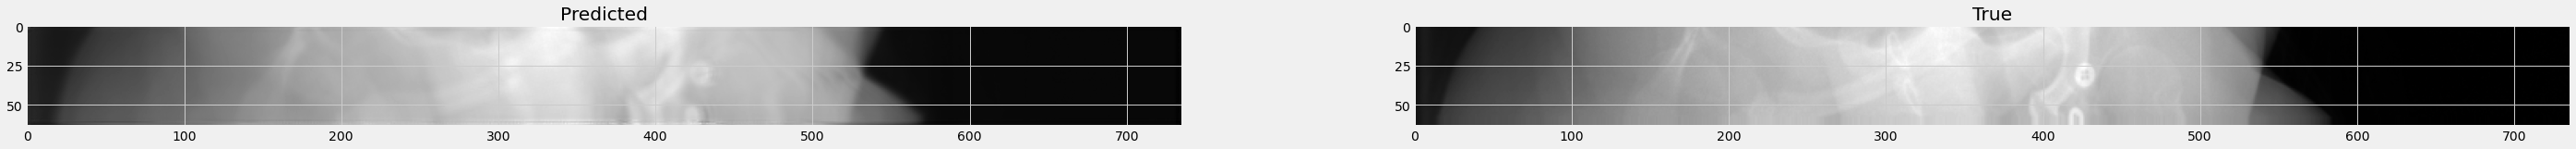

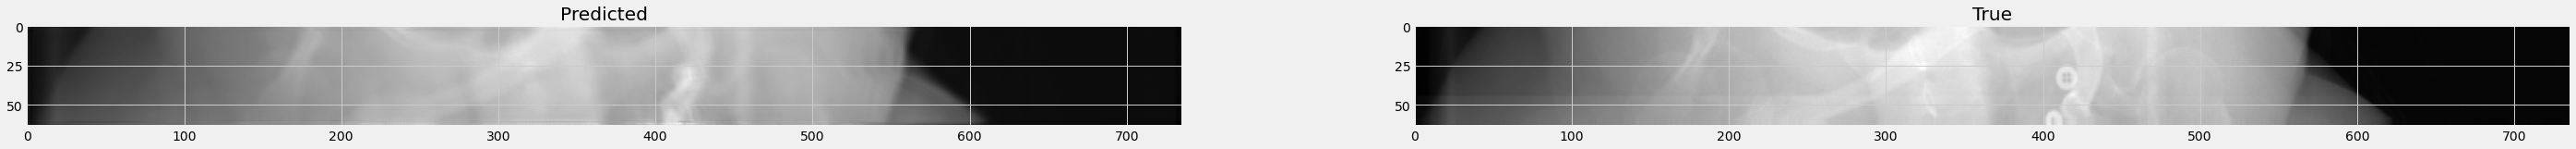

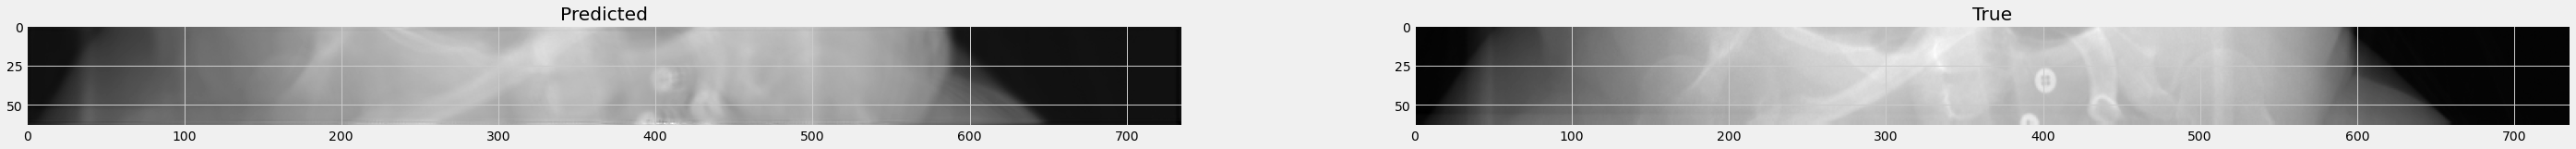

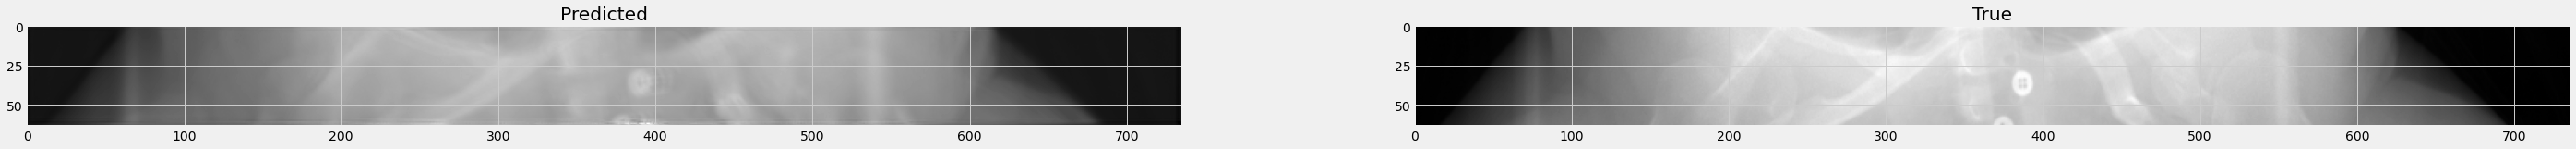

In [28]:
for index, (x, y) in enumerate(val_loader):
#     for index, (batch, y_b) in enumerate(zip(x,y)):
    if index > 5:
        break
    x, y = x[0], y[0] 
    fig, (axs1, axs2) = plt.subplots(1,2, figsize=(44, 10))
#     for i, pic in enumerate(batch):
#         axs[i].imshow(np.array(pic.squeeze(0)))
    
    out = model(x.unsqueeze(0).unsqueeze(0).to(device))[0, 0].detach().cpu().numpy()

    axs1.imshow(out.T, cmap = 'gray')
    axs1.set_title('Predicted')
    
#     plt.show()
#     print(y_b.shape)
#     axs1.legend()
    axs2.imshow(y.cpu().numpy().T, cmap = 'gray')
    axs2.set_title('True')
    
    plt.show()

    # print(pic)
    # print(out)

In [29]:
@torch.no_grad()
def calc_metrics(model, loader):
    ssim_score = 0
    psnr_score = 0
    
#     model = model.to('cpu')
    model.eval()
    with torch.no_grad():
        for batch in loader:

            x, y = batch
            x = x.to(device)
            y = y.to(device)
            out = model(x.unsqueeze(1))
            ssim_score += ssim(out, y)
            psnr_score += psnr(out, y)
    ssim_score /= len(loader)
    psnr_score /= len(loader)
    
    return psnr_score, ssim_score
    

In [30]:
model.load_state_dict(torch.load('DLFinalProjectConvLSTM_3layers.pt'))

<All keys matched successfully>

In [30]:
calc_metrics(model, train_loader)

(tensor(17.9492), 0.935698531684103)

In [31]:
calc_metrics(model, val_loader)

(tensor(17.4702), 0.9488247850111553)

In [32]:
calc_metrics(model, test_loader)

(tensor(18.9947), 0.9627148880333197)

In [33]:
metrics = pd.DataFrame()
metrics['part'] = ['train', 'val', 'test']
metrics['PSNR'] = [17.9492, 17.4702, 19.0]
metrics['SSIM'] = [0.936, 0.949, 0.963]
metrics

,part,PSNR,SSIM
0,train,17.9492,0.936
1,val,17.4702,0.949
2,test,19.0000,0.963
